In [1]:
import csv
import gzip
import time
import os
import pandas as pd
import re
from numpy import where as npwhere
from functools import reduce

def mapMethytilatedCitosine(metfile,intersection_file_path,output_file_path):
    chrs_data = {}
    with gzip.open(metfile, 'rt') as f:
        for line in f:
            chr_index = line.split('\t')[0]
            coordinate_index = int(line.split('\t')[1])
            try:
                chrs_data[chr_index][coordinate_index] = line[:-5]
            except:
                chrs_data[chr_index] = {coordinate_index:line[:-5]}

    with open(intersection_file_path) as f:
        reader = csv.reader(f, delimiter='\t')
        data = list(reader)

    with open(output_file_path, 'a+') as whateverBox:
        for each_box in data:
            box_areas = {}
            box_start = int(each_box[1])
            box_end = int(each_box[2])
            chr_location = each_box[0]
            sequence_identifier = each_box[3]
            # tenemos que aplicar rango desde una posicion inicial porque es un archivo 0 based, si fuese 1 based el rango estaría mal y tendria que restarle
            # uno al archivo al box start
            box_areas['box'] = list(range(box_start, box_end))

            for boxarea in box_areas:
                for coordinate in box_areas[boxarea]:
                    matchline = chrs_data[chr_location].get(coordinate, False)
                    if matchline:
                        whateverBox.write('{}\t{}\t{}\n'.format(matchline, sequence_identifier, boxarea))
                        

def loadFileRemoveMtsAndLowMetReport(replicate):
        bxdf = pd.read_csv(
            replicate,
            sep='\t', 
            names=['chr', 'position', 'strand', 'mets', 'nomets', 'context', 'boxID', 'side'],
            usecols=['chr', 'position', 'strand', 'boxID','mets', 'nomets', 'context']
                )
        bxdf.drop(bxdf[(bxdf.chr == 'Mt') | (bxdf.chr == 'Pt')].index, inplace=True)
        bxdf = bxdf[bxdf['mets'] + bxdf['nomets'] >= 4]
        return bxdf

def calculateValueAsPercentageOfMetCs(replicatedf,replicanamedf):
    replicatedf[replicanamedf] = replicatedf['mets'] / (replicatedf['nomets'] + replicatedf['mets'])
    replicatedf = replicatedf.drop(columns=['mets','nomets'])
    return replicatedf
def calculateValueAsCualitative(replicatedf,replicanamedf):
    """only zero or one, meaning one that there is methylation"""
    replicatedf[replicanamedf] = npwhere(replicatedf['mets']>replicatedf['nomets'], 1, 0)
    replicatedf = replicatedf.drop(columns=['mets','nomets'])
    return replicatedf

In [2]:
working_folder = '/home/joaquin/projects/methylation/data/bisulfite_rep1_rep2_rep3/originallastrep'
intersection_file = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/allThePossiblePeaksnine.bed'

experimentsClasification = {}
for root, dirs, files in os.walk(working_folder):

    for file in files:
        if 'CX_report.txt.gz' in file:
            replicate, hour, condition =root.strip().split('/')[-3:]
            experimentName = hour+condition
            experimentsClasification.setdefault(experimentName, [])
            targetMetFilename = root+'/'+file
            outputfile = targetMetFilename[:-3] + 'peakMets.tsv'
            experimentsClasification[experimentName].append(outputfile)
#             mapMethytilatedCitosine(targetMetFilename,intersection_file,outputfile)

            

In [3]:
allthedata = []
for experimentCondition in experimentsClasification:
    listOfDfReplicatesPercentageOfMetCs = []
    listOfDfReplicatesCualitative = []
    listOfNamesReplicates = []
    for replicatePath in experimentsClasification[experimentCondition]:

        replicaname =  experimentCondition+replicatePath.split('/')[-4]
        replicateDf = loadFileRemoveMtsAndLowMetReport(replicatePath)

        replicateDfPercentageOfMetCs = calculateValueAsPercentageOfMetCs(replicateDf,replicaname)

#         replicateDfCualitative = calculateValueAsCualitative(replicateDf,replicaname)
#         print(replicateDfCualitative)
        listOfNamesReplicates.append(replicaname)
        listOfDfReplicatesPercentageOfMetCs.append(replicateDfPercentageOfMetCs)
#         listOfDfReplicatesCualitative.append(replicateDfCualitative)
        
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['chr','position', 'strand','context','boxID'],
                                                how='outer'), listOfDfReplicatesPercentageOfMetCs).fillna(0)
    df_merged[experimentCondition] = df_merged[listOfNamesReplicates].mean(axis=1)
    df_merged = df_merged.drop(columns=listOfNamesReplicates)
    allthedata.append(df_merged)
finaldf = reduce(lambda  left,right: pd.merge(left,right,on=['chr','position', 'strand','context','boxID'],
                                                how='outer'), allthedata).fillna(0)

In [6]:
finaldf.to_csv('bisulfite.tsv',sep='\t', index=False)

In [ ]:
finaldf.to_csv('bisulfite.tsv',sep='\t', index=False)


In [4]:

CGdf = finaldf[(finaldf['context'] == 'CG')]

In [5]:
CGdf

,chr,position,strand,context,boxID,6ACC,6Mock,6JA,24ACC,24Mock,24JA,1ACC,1Mock,1JA
0,1,1438,+,CG,1:1538,0.000000,0.0,0.000000,0.0,0.0,0.030303,0.0,0.037037,0.000000
1,1,1439,-,CG,1:1538,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
32,1,1540,+,CG,1:1538,0.000000,0.0,0.037037,0.0,0.0,0.000000,0.0,0.000000,0.000000
33,1,1541,-,CG,1:1538,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
67,1,1633,+,CG,1:1538,0.083333,0.0,0.000000,0.0,0.0,0.055556,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353430,5,11321948,+,CG,5:11321894,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.333333
4353432,5,11321952,+,CG,5:11321894,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250000
4353440,5,11885364,+,CG,5:11885412,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.083333
4353452,5,14510810,+,CG,5:14510818,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250000


In [12]:
CGdf

,6ACC,6Mock,6JA,24ACC,24Mock,24JA,1ACC,1Mock,1JA
boxID,,,,,,,,,
1:1538,0.000000,0.0,0.000000,0.0,0.0,0.030303,0.0,0.037037,0.000000
1:1538,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1:1538,0.000000,0.0,0.037037,0.0,0.0,0.000000,0.0,0.000000,0.000000
1:1538,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1:1538,0.083333,0.0,0.000000,0.0,0.0,0.055556,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
5:11321894,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.333333
5:11321894,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250000
5:11885412,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.083333


In [8]:
import pandas as pd
import seaborn as sns
import math
# CGdf = CGdf.drop(columns=['chr','position', 'strand','context','boxID'])
# CGdf = CGdf.set_index()
CGdf = CGdf[['1Mock','6Mock','24Mock','1ACC','6ACC','24ACC','1JA','6JA','24JA']]
# 

<AxesSubplot:ylabel='boxID'>

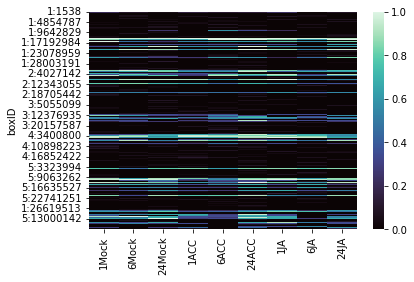

In [14]:
CGdf = CGdf[['1Mock','6Mock','24Mock','1ACC','6ACC','24ACC','1JA','6JA','24JA']]


<AxesSubplot:>

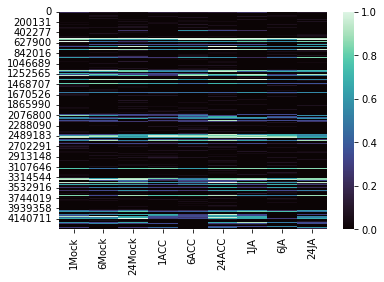

In [9]:
sns.heatmap(CGdf, cmap="mako")

<AxesSubplot:ylabel='boxID'>

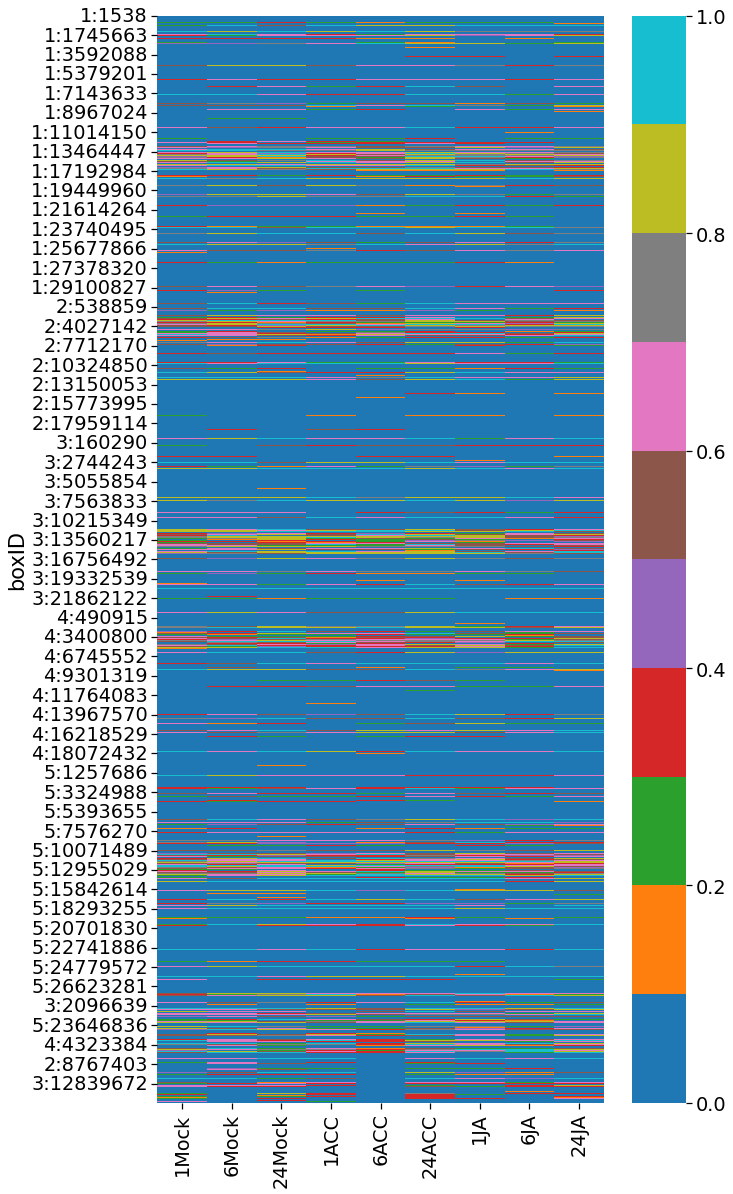

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,20))         # Sample figsize in inches
sns.heatmap(CGdf, cmap="tab10", ax=ax)
# sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 2.5, 'font.family':'Helvetica'})
# sns.heatmap(CGdf, cmap="tab10")

<AxesSubplot:ylabel='boxID'>

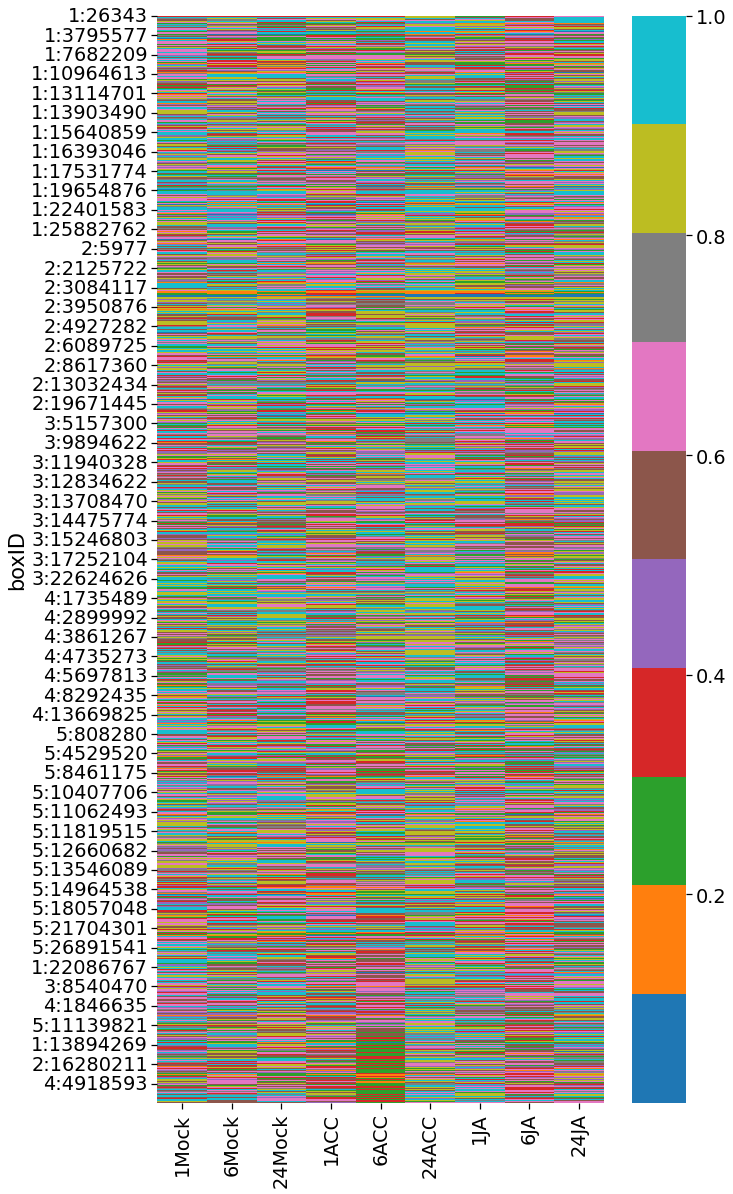

In [19]:
Sinmenosde1 = CGdf[(CGdf >= 0.01).all(1)]
fig, ax = plt.subplots(figsize=(10,20))         # Sample figsize in inches
sns.heatmap(Sinmenosde1, cmap="tab10", ax=ax)


<AxesSubplot:ylabel='boxID'>

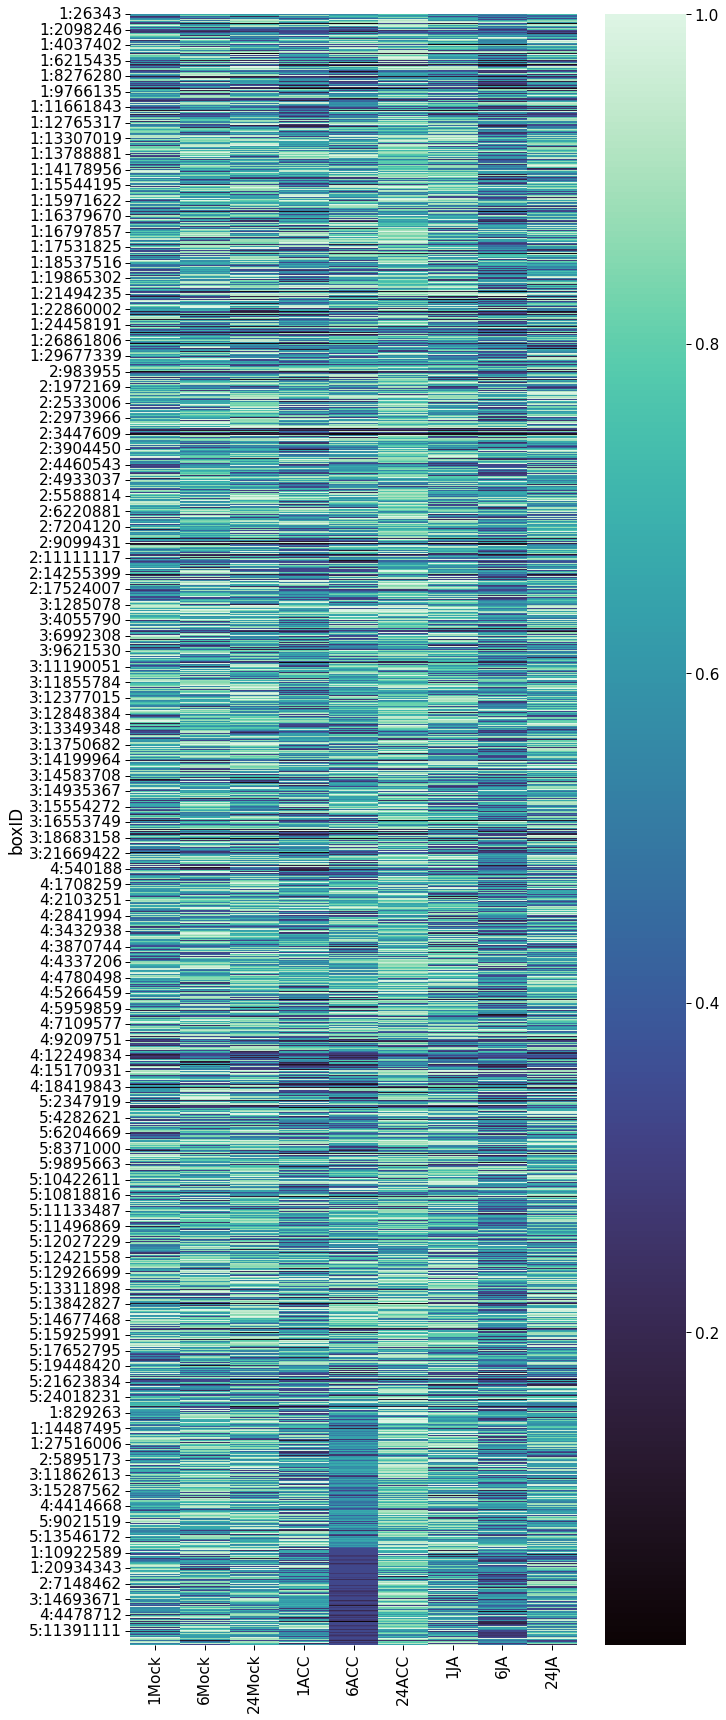

In [26]:
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5, 'font.family':'Helvetica'})
fig, ax = plt.subplots(figsize=(10,30))         # Sample figsize in inches
sns.heatmap(Sinmenosde1, cmap="mako", ax=ax)

In [27]:
Sinmenosde1

,1Mock,6Mock,24Mock,1ACC,6ACC,24ACC,1JA,6JA,24JA
boxID,,,,,,,,,
1:26343,0.518398,0.477778,0.277778,0.130952,0.066667,0.400000,0.500000,0.142857,0.222222
1:26343,0.416667,0.333333,0.158730,0.055556,0.416667,0.435897,0.133333,0.047619,0.450000
1:26343,0.597222,1.000000,0.333333,0.333333,0.600000,0.944444,0.666667,0.629630,0.333333
1:26343,0.944444,0.952381,0.666667,0.625000,0.857143,0.903030,0.666667,0.666667,0.883333
1:26343,0.599359,0.861111,0.333333,0.285714,0.666667,1.000000,0.666667,0.619048,0.333333
...,...,...,...,...,...,...,...,...,...
5:26415422,0.333333,0.333333,0.666667,0.666667,0.333333,0.666667,0.791667,0.666667,0.333333
5:26942880,0.916667,1.000000,1.000000,0.619048,0.333333,0.925926,0.666667,0.629630,0.888889
5:26942928,0.916667,1.000000,1.000000,0.619048,0.333333,0.925926,0.666667,0.629630,0.888889


In [11]:
for col in ['1Mock','6Mock','24Mock','1ACC','6ACC','24ACC','1JA','6JA','24JA']:
    print(col, CGdf[col].mean()*100)

1Mock 14.266962547346406
6Mock 14.639200134924934
24Mock 14.721083506703936
1ACC 12.884728256113137
6ACC 13.147907681345114
24ACC 16.3555154595674
1JA 14.295988185789636
6JA 11.738542601948454
24JA 14.300245230595479


In [32]:
CHHdf = finaldf[(finaldf['context'] == 'CHH')]
for col in ['1Mock','6Mock','24Mock','1ACC','6ACC','24ACC','1JA','6JA','24JA']:
    print(col, CHHdf[col].mean()*100)

1Mock 1.9868856852103804
6Mock 1.97569692809902
24Mock 2.031532550314727
1ACC 1.9018600634222338
6ACC 1.9477607309072338
24ACC 2.1293040608192575
1JA 1.9241197372320058
6JA 1.653763921217246
24JA 1.8964386791258299


In [33]:
CHGdf = finaldf[(finaldf['context'] == 'CHG')]
for col in ['1Mock','6Mock','24Mock','1ACC','6ACC','24ACC','1JA','6JA','24JA']:
    print(col, CHGdf[col].mean()*100)

1Mock 5.463106910502927
6Mock 5.646806780966278
24Mock 5.778884144813374
1ACC 5.012687684736789
6ACC 5.1500822009141585
24ACC 6.194442281867916
1JA 5.44442841921025
6JA 4.493692520538844
24JA 5.425878740220659


In [ ]:
def mergeResultsMets(folder):
    with cd('/home/joaquin/projects/methylation/data/bisulfite_rep1_rep2/reports/'):
        file_names = os.listdir()
        for rep in ['rep1', 'rep2']:
            for side in ['.motif.', 'motifSide']:
                for metcontex in ['CG', 'CHG', 'CHH']:
                    for box in ['G_box', 'GAC_box', 'PBE_box', 'GCC_box', 'TG_box']:
                        boxfiles = []
                        for file in file_names:
                            # print(file_names)
                            # print('hello')
                            if rep in file and side in file and metcontex in file and file.startswith(box):
                                # print('hello')
                                if '_merged_intersect.csv' not in file:
                                    boxfiles.append(file)
                        # print(boxfiles)
                        
                        if box + rep + side + metcontex + '_merged_intersect.csv' in file_names:
                            experiment1df = pd.read_csv(box + rep + side + metcontex + '_merged_intersect.csv')
                            experiment2df = pd.read_csv(boxfiles[0])
                            mergedDf = experiment1df.merge(experiment2df, on=['chr', 'position', 'strand','boxID'], how='outer')
                            mergedDf.to_csv(box + rep + side + metcontex + '_merged_intersect.csv', index=False)
                            os.remove(boxfiles[0])
                        elif len(boxfiles) == 2:
                            # print('hello')
                            experiment1df = pd.read_csv(boxfiles[0])
                            experiment2df = pd.read_csv(boxfiles[1])
                            # print(experiment1df)
                            mergedDf = experiment1df.merge(experiment2df, on=['chr', 'position', 'strand','boxID'], how='outer')
                            mergedDf.to_csv(box + rep + side + metcontex + '_merged_intersect.csv', index=False)
                            os.remove(boxfiles[0])
                            os.remove(boxfiles[1])
